### Introduction
This assignment follows the same structure as Assignment 6, where we developed an artificial neural network (ANN) to identify handwritten digits in the MNIST dataset. In this assignment, we are asked to explore the convolutional neural networks (CNNs) to label cat and dog images provided by end users automatically. The 2,000 images on canvas came from the machine learning competition website Kaggle. We need to use the TensorFlow library to build a CNN model that correctly identify 2,000 greyscales (128 x 128 pixels) cat and dog images in various settings, backgrounds, and angles. To prepare the data for analysis, we need to turn each picture into a Numpy array which we can easily concatenate, reshape, and manipulate.  We will scale the images from various resolutions and then tune the convolutional network layer sizes, pooling layers, optimization, and loss functions. We are most concerned about achieving the highest possible accuracy in image classification. That is, we should be willing to sacrifice training time for model accuracy. 

### Import Packages and Load the Data

In [1]:
%matplotlib inline
# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings("ignore")

# import base packages into the namespace for this program
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from time import time
from random import shuffle 

In [2]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 43

# To make output stable across runs
def reset_graph(seed= RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

### Data Exploration and Data Preparationand

Image data comes from: <br>
https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data <br>
Downloaded 1000 cats and 1000 dogs images from canvas 

In [3]:
# read in 1000 cats and 1000 dogs grayscale 128x128 files
cats = np.load('cats_dogs_64-128/cats_1000_128_128_1.npy')
dogs = np.load('cats_dogs_64-128/dogs_1000_128_128_1.npy')

print('cats data shape:', cats.shape)
print('dogs data shape:', dogs.shape)

cats data shape: (1000, 128, 128, 1)
dogs data shape: (1000, 128, 128, 1)


In [4]:
# generating the labels: cats = 0 and dogs = 1
y_cats = np.zeros((1000), dtype = np.int32)
y_dogs = np.ones((1000), dtype = np.int32)

In [5]:
# function of displaying grayscale images
def show_grayscale_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

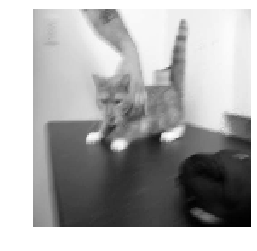

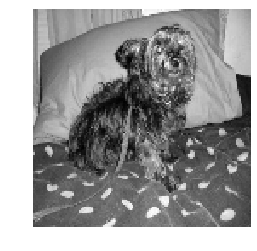

In [6]:
# examine first cat and first dog grayscale images
show_grayscale_image(cats[0,:,:,0])
show_grayscale_image(dogs[0,:,:,0])

In [7]:
# combine cats and dogs into one array
pets = np.concatenate((cats, dogs), axis = 0) 
# combine label of cats and dogs into one place
y_pets = np.concatenate((y_cats, y_dogs), axis = 0) 

print('pets data shape:  ', pets.shape)
print('y_pets data shape:', y_pets.shape)

pets data shape:   (2000, 128, 128, 1)
y_pets data shape: (2000,)


In [8]:
# shuffle the data and split it into the train and the testing sets
X_train, X_test, y_train, y_test = train_test_split(
    pets, y_pets, test_size = 0.2, shuffle = True, stratify = y_pets,
    random_state = RANDOM_SEED)

In [9]:
# normalize image by dividing the values into 255.0
X_train /= 255.0
X_test /= 255.0

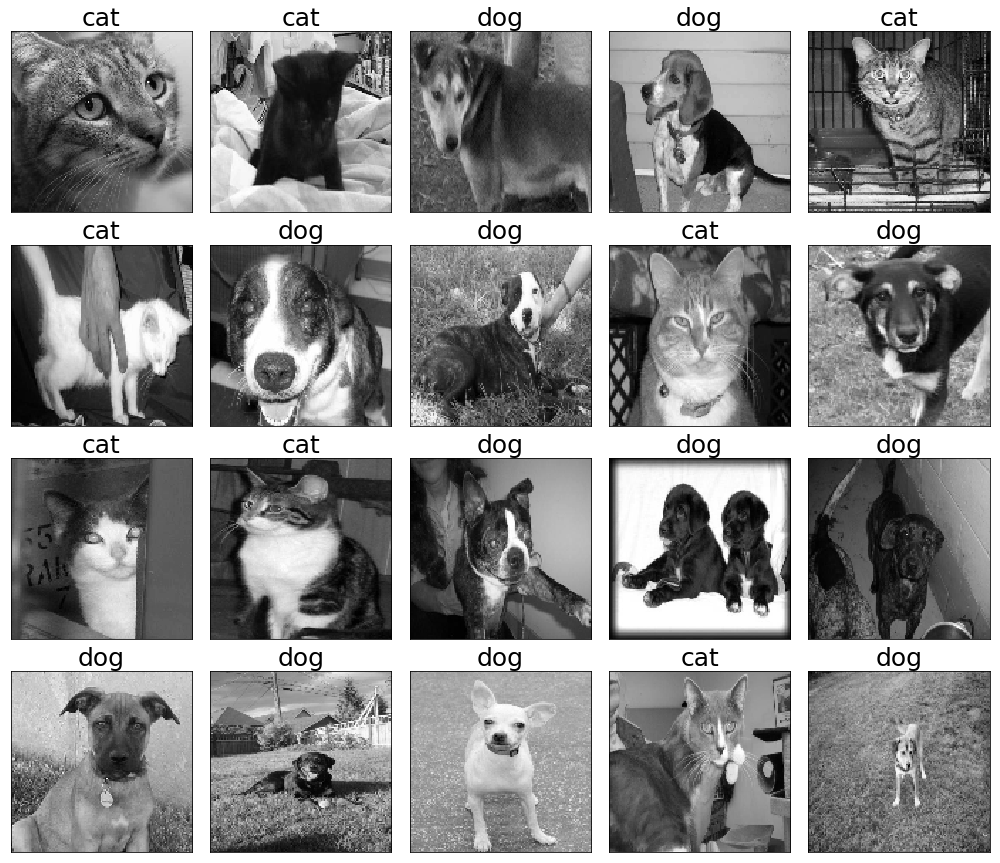

In [10]:
# test if labels working after shuffle
plt.figure(figsize = (14, 12))
for i in range(0, 20):
    plt.subplot(4, 5, i + 1)
    grid_data = X_train[i].reshape(128, 128)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap='gray')
    plt.title(('cat' if y_train[i] == 0 else 'dog'),
        fontsize = 25)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout();

In [11]:
# examine the shape of the data after splitting the train and the testing set
print('train data shape:', X_train.shape)
print('test data shape: ', X_test.shape)

train data shape: (1600, 128, 128, 1)
test data shape:  (400, 128, 128, 1)


### Model Exploration

In [12]:
#function of CNN
def set_model():
    
    #develop sequential model
    model = tf.keras.Sequential()

    model.add(Convolution2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:], activation='relu'))
    model.add(Convolution2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', 
                  optimizer = RMSprop(lr=1e-4), 
                  metrics = ['accuracy'])
    return model

In [13]:
#splitting the code into two chunks
def cnn_model(batch_size, epochs):
        
    #recall the previous function    
    model = set_model()
    
    #processing time start
    start = time()
    
    #fit the model 
    #epochs is a number of times to look over dataset
    model.fit(X_train, y_train, batch_size = batch_size, 
              epochs = epochs,verbose = 0)
    
    #processing time end
    end = time()
    proc_time = np.round((end - start), 2)

    #evaluate model
    score_train, acc_train = np.round(model.evaluate(X_train, y_train), 3)
    score_test, acc_test = np.round(model.evaluate(X_test, y_test), 3)

    # performance score table
    col_names = ['Batch Size', 'Epochs', 'Processing Time',\
                 'Training Set Accuracy', 'Test Set Accuracy']
    perf = pd.DataFrame([batch_size, epochs, proc_time, acc_train, acc_test],\
                        columns = [''], index = col_names).T
    
    return model, perf

In [15]:
# Run 1: batch size is 8, epochs (number of times to look over dataset) is 5
model_1, perf_1 = cnn_model(batch_size = 8, epochs = 5);
perf_1

400/400 [==============================] - 3s 7ms/sample - loss: 0.6533 - accuracy: 0.6275


,Batch Size,Epochs,Processing Time,Training Set Accuracy,Test Set Accuracy
,8.0,5.0,262.95,0.619,0.627


In [16]:
# Run 2: batch size is 8, epochs (number of times to look over dataset) is 10
model_2, perf_2 = cnn_model(batch_size = 8, epochs = 10);
perf_2

400/400 [==============================] - 3s 6ms/sample - loss: 0.6269 - accuracy: 0.6850


,Batch Size,Epochs,Processing Time,Training Set Accuracy,Test Set Accuracy
,8.0,10.0,536.62,0.704,0.685


In [17]:
# Run 3: batch size is 16, epochs (number of times to look over dataset) is 5
model_3, perf_3 = cnn_model(batch_size = 16, epochs = 5);
perf_3

400/400 [==============================] - 3s 7ms/sample - loss: 0.6605 - accuracy: 0.6150


,Batch Size,Epochs,Processing Time,Training Set Accuracy,Test Set Accuracy
,16.0,5.0,245.32,0.627,0.615


In [18]:
# Run 4: batch size is 16, epochs (number of times to look over dataset) is 10
model_4, perf_4 = cnn_model(batch_size = 16, epochs = 10);
perf_4

400/400 [==============================] - 3s 7ms/sample - loss: 0.6256 - accuracy: 0.6850


,Batch Size,Epochs,Processing Time,Training Set Accuracy,Test Set Accuracy
,16.0,10.0,489.4,0.715,0.685


### Evaluation of Performance 

In [19]:
#performance chart example
pd.concat([perf_1, perf_2, perf_3, perf_4], axis = 0)

,Batch Size,Epochs,Processing Time,Training Set Accuracy,Test Set Accuracy
,8.0,5.0,262.95,0.619,0.627
,8.0,10.0,536.62,0.704,0.685
,16.0,5.0,245.32,0.627,0.615
,16.0,10.0,489.40,0.715,0.685


The batch size (number of samples per evaluation step) did not impact the accuracy; however, as we increase the epochs (number of iteration to train the model over the entire dataset), the accuracy and the processing time increased. 

### Evaluation of Results

In [22]:
Y_pred = np.rint(model_4.predict(X_test)).astype("int")

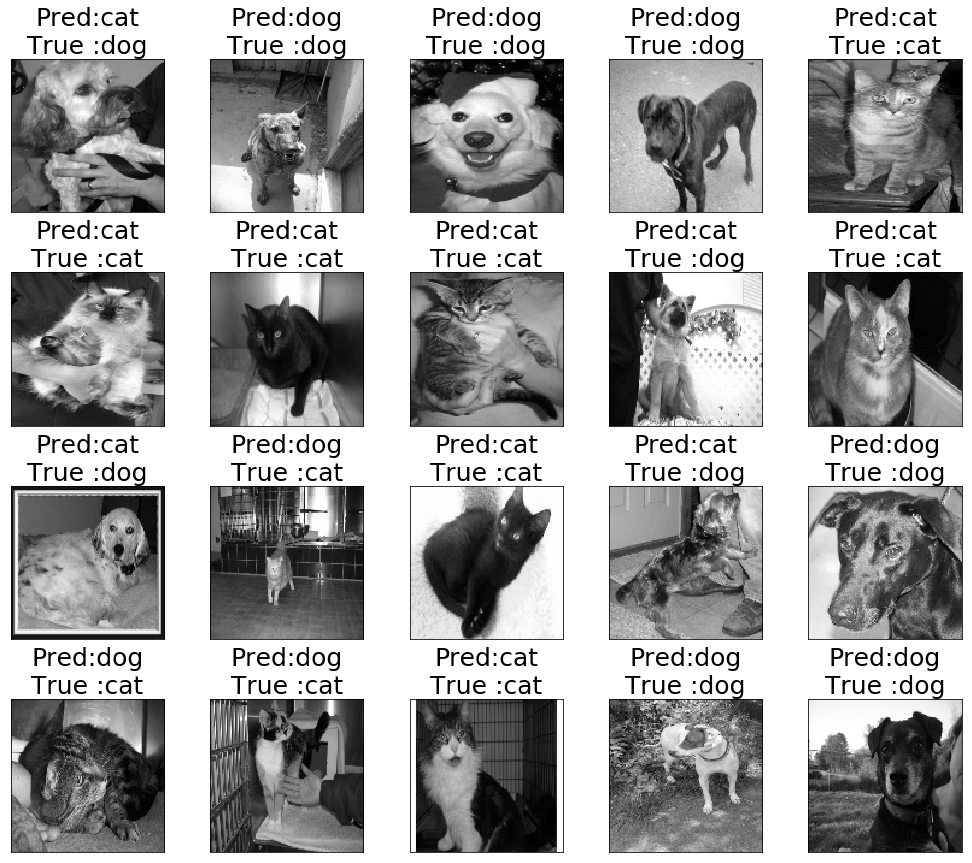

In [23]:
# plot predicted y of model_1

plt.figure(figsize = (14, 12))
for i in range(0, 20):
    plt.subplot(4, 5, i + 1)
    grid_data = X_test[i].reshape(128, 128)  
    plt.imshow(grid_data, interpolation = "none", cmap='gray')
    plt.title("Pred:{}\nTrue :{}".format(
        ('cat' if Y_pred[i] == 0 else 'dog'),
        ('cat' if y_test[i] == 0 else 'dog')),
        fontsize = 25)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout();

## visualization of a single digit
## plt.imshow(X_train[100].reshape(128, 128), cmap = 'gray');

In [24]:
# Predict the values from the validation dataset
Y_pred_classes = Y_pred

# Convert validation observations to one hot vectors
Y_true = y_test

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
## confusion_mtx

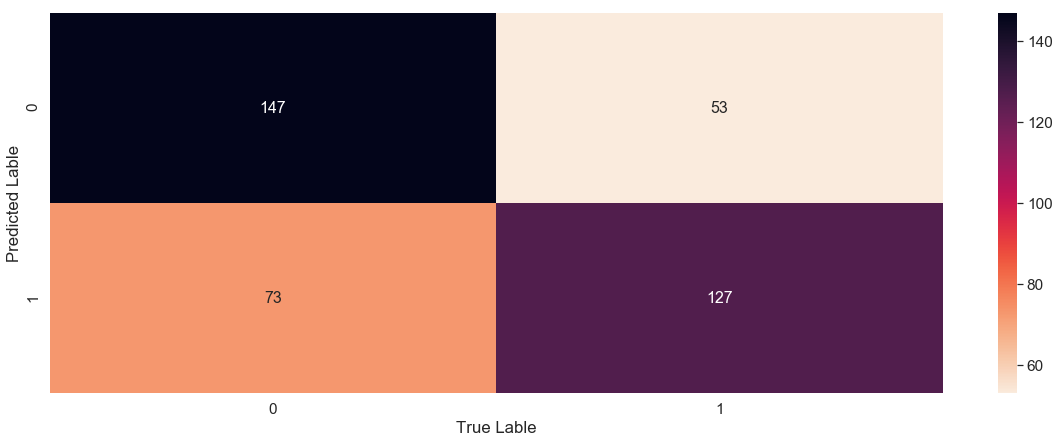

In [25]:
# plot confusion matrix
sns.set(font_scale=1.4)
df_cm = pd.DataFrame(confusion_mtx, index = [i for i in range(2)],
                  columns = [i for i in range(2)])
plt.figure(figsize = (20,7))
sns.heatmap(df_cm, annot=True, fmt = ".0f", cmap = sns.cm.rocket_r, annot_kws={'size':16})
plt.xlabel('True Lable')
plt.ylabel('Predicted Lable');

The confusion matrix highlights that some of the predicted pet (dog or cat) images of model two were misclassified: 

* 33.2% cats were predicted as dogs
* 29.4% dogs were predicted as cats

However, about 70% of the time our model was able to correctly identify 2,000 greyscales (128 x 128 pixels) cat and dog images in various settings, backgrounds, and angles. 

### Summary

In this assignment, we are asked to find the highest possible accuracy in image classification. The recommendation is to use model 4 – the convolution model (CNN). Although it takes a lot more memory to process the model, the accuracy of the test predictions is much higher than the other models. Please note that each time when I ran the model, I got different accuracy scores. The highest training accuracy was 86%, and testing accuracy was 75%. Since rerunning was a lengthy process, I decided to stick with the latest accuracy scores, which turned out less than what I expected.

We looked at improving on tuning the batch size (number of samples per evaluation step) and epochs (number of iterations to train the model over the entire dataset). With these parameters, we derived the processing time and accuracy scores for training and testing sets. According to the benchmark study (table above), the batch size did not impact the accuracy; however, higher epochs gave us better accuracy. The fourth model achieved the optimal results by using the following parameters: batch size 16 and epochs number 10 with Relu activation. 
 
These results are satisfactory; however, accurately predicting 3 out of every four images is not the results we were hoping. The 2,000 greyscales (128 x 128 pixels) cat and dog images on canvas was a sample of 25,000 images in Kaggle.com.  CNN works with larger datasets. To increase accuracy, we need to full dataset (25,000 images) from Kaggle.com.